# Übung 7: Histogram of Oriented Gradients
## Paper lesen
Schau mal in den Bereich "Resources" im KVV und lies die HOG-Originalarbeit von Dalal und Triggs von 2005 und die gute Zusammenfassung von Tomasi (diese würde ich zuerst lesen). Jetzt solltest Du keine Probleme mit der Implementierung des Algorithmus haben! 

## MIT-DB für Personen
Unter http://cbcl.mit.edu/cbcl/software-datasets/PedestrianData.html kannst Du Dir den kompletten Bilddatensatz herunterladen, den wir später für die Klassifikation eines unbekannten Bildes benötigen. btw: Das Dateiformat der Bilder ist PPM ("portable pixel map"). Nicht jeder Viewer kann das anzeigen! Glücklicherweise aber Scikit-Image!

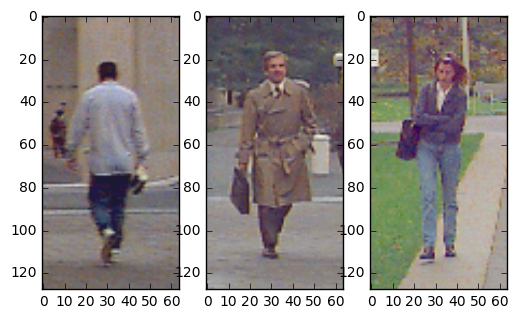

In [1]:
%matplotlib inline 
from skimage import io,color, transform
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import warnings
warnings.filterwarnings("ignore")

pers1 = io.imread('images/per00002.ppm')
pers2 = io.imread('images/per00007.ppm')
pers3 = io.imread('images/per00014.ppm')

fig = plt.figure()
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(pers1)
ax2.imshow(pers2)
ax3.imshow(pers3)


## Gradienten und -richtungen
Implementiere zunächst die Extraktion des Gradienten mit den zentralen Differenzen (nicht mit Sobel!). Übersetze die beiden Ergebnismatrizen in ein Bild das die Gradientenrichtung (einen Winkel pro Pixel) beinhaltet. Zeige dieses Bild jeweils für die drei Eingabebilder oben an.  

Wall time: 128 ms


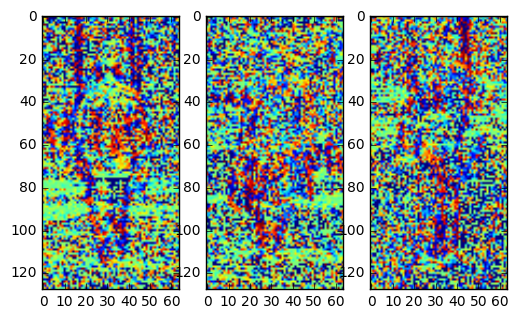

In [2]:
%%time

def getGradientConv(image):
    Hx = np.array([[-1, 0, 1]])
    Hy = Hx.T
    Dx = ndimage.convolve(image, Hx)
    Dy = ndimage.convolve(image, Hy)  
    mu = np.hypot(Dx, Dy)
    theta = 180/np.pi * (np.arctan2(Dy, Dx) % np.pi)
    return (mu, theta)

ergM1, ergT1 = getGradientConv(color.rgb2grey(pers1))
ergM2, ergT2 = getGradientConv(color.rgb2grey(pers2))
ergM3, ergT3 = getGradientConv(color.rgb2grey(pers3))

fig = plt.figure()
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax1.imshow(ergT1)
ax2.imshow(ergT2)
ax3.imshow(ergT3)

## Gradientenrichtungshistogramme (GRH)
Nun implementiere eine Funktion, die GRH auf Bildzellen erzeugt. Übergeben an die Funktion ein Gradientenrichtungsbild wie oben beschrieben. Die Bildzellen sollen 8 x 8 Pixel groß sein. Bitte nicht  das Voting mit "bi-linearer Interpolation" vergessen (wichtig!). Zeige das GRH für das Eingabebild "star.png" einmal mit und einmal ohne Interpolation an! Jetzt rotiere das Bild um 2° und zeige nochmal beide Varianten des GRHs!

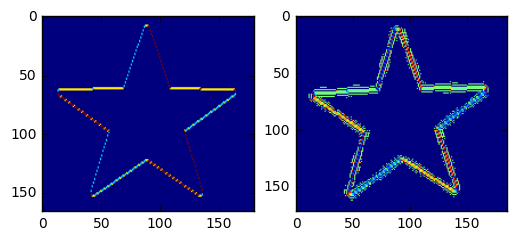

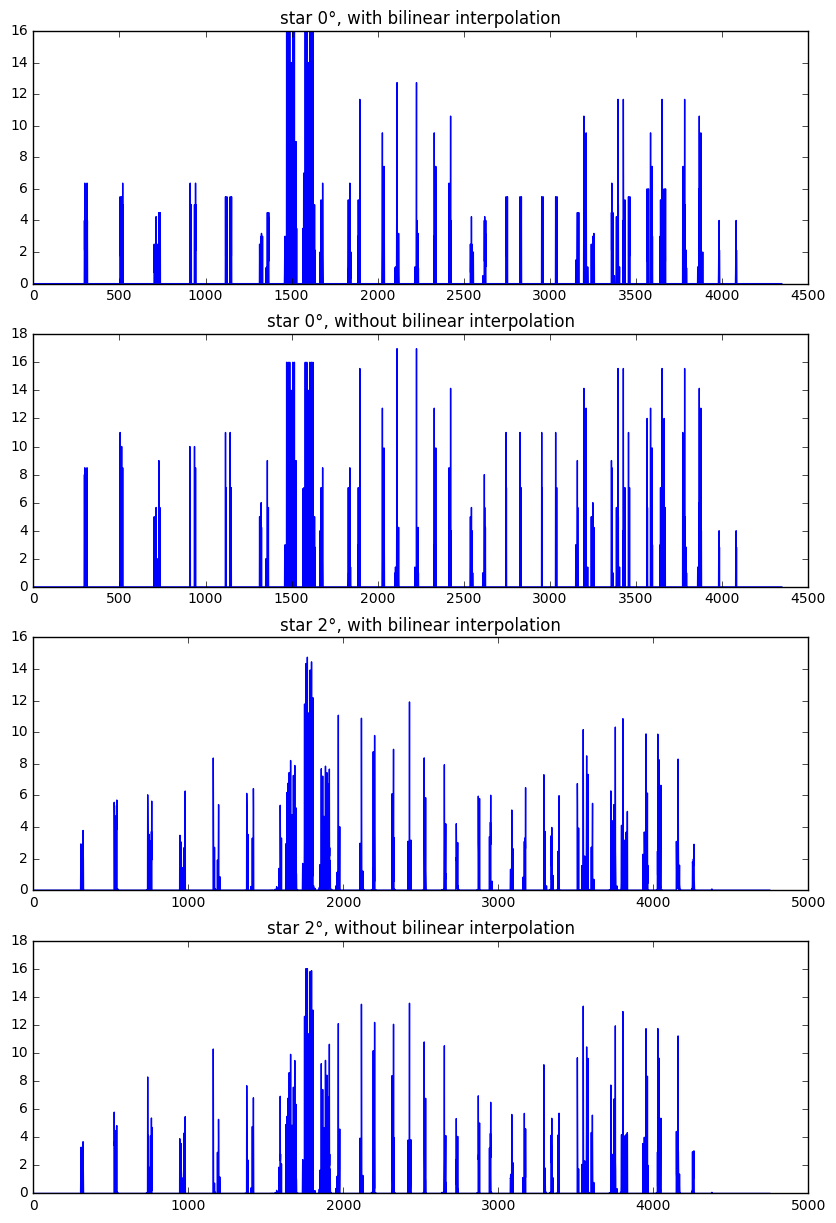

In [3]:
star = io.imread('images/star.png')
ergStarM1, ergStarT1 = getGradientConv(color.rgb2grey(star))
ergStarM2, ergStarT2 = getGradientConv(color.rgb2grey(
        ndimage.rotate(star, 2, mode='nearest')))

fig = plt.figure()
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.imshow(ergStarT1)
ax2.imshow(ergStarT2)

def cell2Histo(grad, magn, bilinear):
    w = 20
    B = 9
    hist = np.zeros((B))
    grad = grad.ravel()
    magn = magn.ravel()
    if bilinear:
        for i in range(len(grad)):
            mu = magn[i]
            theta = grad[i]
            Bin = np.floor(theta/w-0.5) % B
            center = w*(Bin+0.5)
            hist[Bin]       += mu*(((center + w - theta) % 180) / w)
            hist[(Bin+1)%B] += mu*(((theta - center) % 180) / w)
    else:
        for i in range(len(grad)):
            hist[(np.floor(grad[i]/w)) % B] += magn[i]
    return hist

def getGRH(grb, gmb, bilinear):
    SIZE = 8
    n, m = grb.shape
    grh = []
    for y in range(0, n, SIZE):
        for x in range(0, m, SIZE):
            grad = grb[y:y+SIZE, x:x+SIZE]
            magn = gmb[y:y+SIZE, x:x+SIZE]
            grh = np.append(grh, cell2Histo(grad, magn, bilinear))
    return grh

star_grhYES = getGRH(ergStarT1, ergStarM1, True)
star_grhNO = getGRH(ergStarT1, ergStarM1, False)
starRot_grhYES = getGRH(ergStarT2, ergStarM2, True)
starRot_grhNO = getGRH(ergStarT2, ergStarM2, False)
fig = plt.figure(figsize=(10, 15))
a=fig.add_subplot(411)
plt.plot(star_grhYES)
a.set_title('star 0°, with bilinear interpolation')
b=fig.add_subplot(412)
plt.plot(star_grhNO)
b.set_title('star 0°, without bilinear interpolation')
c=fig.add_subplot(413)
plt.plot(starRot_grhYES)
c.set_title('star 2°, with bilinear interpolation')
d=fig.add_subplot(414)
plt.plot(starRot_grhNO)
d.set_title('star 2°, without bilinear interpolation')    
    

## Block- und ROI-Normierung und Erstellung des Deskriptors
Gegeben ein ROI fester Größe (128 x 64 Pixel) erstelle einen Deskriptor, wie in der Vorlesung beschrieben (inklusive Normierungen der Blöcke und des gesamten ROI). Hierzu bitte die vorberechneten Zell-Histogramme für die Blöcke wiederverwenden! 
Berechne den Deskriptor für die drei Bilder oben und für die unbekannten Bilder "unknown1.png" und "unknown2.png". Jetzt vergleiche die unbekannten mit den drei Personeninstanzen und berechne den Euklidischen Abstand der Deskriptoren. Welches Bild hat einen kleineren Abstand zu den Personen? 


In [4]:
def calcDescriptor(GRH, threshold):
    GRH = np.reshape(GRH, (16,72))
    h = []
    e = 0.0000001
    LEAP = 9
    for y in range(0, 15):
        for x in range(0, 63, LEAP):
            block = []
            block = np.append(block, GRH[y, x:x+2*LEAP])
            block = np.append(block, GRH[y+1, x:x+2*LEAP])
            blockNorm = block / (np.linalg.norm(block) + e)
            h = np.append(h, blockNorm)
    h = h / (np.linalg.norm(h) + e)
    h[h > threshold] = threshold
    descriptor = h / (np.linalg.norm(h) + e)
    return descriptor

def pic2hog(pic, threshold=0.05):
    M1, T1 = getGradientConv(color.rgb2grey(pic))
    return calcDescriptor(getGRH(T1, M1, True), threshold)

pers1_HOG = pic2hog(pers1)
pers2_HOG = pic2hog(pers2)
pers3_HOG = pic2hog(pers3)
unknown1_HOG = pic2hog(io.imread('images/unknown1.png'))
unknown2_HOG = pic2hog(io.imread('images/unknown2.png'))

d_unk1TOpers1 = np.linalg.norm(unknown1_HOG - pers1_HOG)
d_unk1TOpers2 = np.linalg.norm(unknown1_HOG - pers2_HOG)
d_unk1TOpers3 = np.linalg.norm(unknown1_HOG - pers3_HOG)
d_unk1TOpersMean = np.mean([d_unk1TOpers1, d_unk1TOpers2, d_unk1TOpers3])
d_unk2TOpers1 = np.linalg.norm(unknown2_HOG - pers1_HOG)
d_unk2TOpers2 = np.linalg.norm(unknown2_HOG - pers2_HOG)
d_unk2TOpers3 = np.linalg.norm(unknown2_HOG - pers3_HOG)
d_unk2TOpersMean = np.mean([d_unk2TOpers1, d_unk2TOpers2, d_unk2TOpers3])

print("Abstand von unknown1 zu...")
print("Person 1: "+str(d_unk1TOpers1))
print("Person 2: "+str(d_unk1TOpers2))
print("Person 3: "+str(d_unk1TOpers3))
print("Durchschnittlich: "
      +str(d_unk1TOpersMean))
print("\nAbstand von unknown2 zu...")
print("Person 1: "+str(d_unk2TOpers1))
print("Person 2: "+str(d_unk2TOpers2))
print("Person 3: "+str(d_unk2TOpers3))
print("Durchschnittlich: "
      +str(d_unk2TOpersMean))
print("\n-> "+"unknown1 hat also den kleineren Abstand zu den Personen."
      if (d_unk1TOpersMean < d_unk2TOpersMean) 
      else "unknown2 hat also den kleineren Abstand zu den Personen.")


Abstand von unknown1 zu...
Person 1: 0.939595303278
Person 2: 0.953941953548
Person 3: 0.923007445762
Durchschnittlich: 0.938848234196

Abstand von unknown2 zu...
Person 1: 0.991523078223
Person 2: 1.00495695113
Person 3: 0.975621353315
Durchschnittlich: 0.990700460889

-> unknown1 hat also den kleineren Abstand zu den Personen.


# Zusatzaufgabe
## ROI-Scanning und Klassifikation
Zum HOG-Algorithmus gehört natürlich auch das durchscannen eines Bildes. Hinweis: Die Verschiebungsbreite des ROI ("stride") ist gleich der Zellbreite (8 px). Implementiere den Scan über ein Testbild für eine feste ROI-Größe. Der ROI-Deskriptor soll nun mit der Personen-Datenbank abgeglichen werden. Im einfachsten Fall könnte das ein kNN-Klassifikator sein. Achtung: da wir keine Negativbeispiele in der Datenbank haben, musst Du Dich für einen Abstandsschwellwert entscheiden, ab dem zu klassifizierende Samples als Nicht-Personen klassifiziert werden. Unter /images/pedestrian_test/ findest Du eine Auswahl an Testbildern (plus ground truth). Den originalen Satz findest Du unter: http://iris.usc.edu/Vision-Users/OldUsers/bowu/DatasetWebpage/dataset.html. 

Wer diese Aufgabe komplett löst sichert sich 5 Bonuspunkte für die Klausur (entsprechen ca. 10 %)!



### DB mit verschiedenen Thresholds einlesen

In [5]:
# DB einlesen -> in HOG-Deskriptor umwandeln
#image_hogs4 = {}
image_hogs5 = {}
#image_hogs6 = {}
path = "images/pedestrians128x64/per%s.ppm"
for ped in range(1,925):
    ped_num = "%05i" % ped
    #image_hogs4[ped-1] = pic2hog(io.imread(path % ped_num), 0.04)
    image_hogs5[ped-1] = pic2hog(io.imread(path % ped_num), 0.05)
    #image_hogs6[ped-1] = pic2hog(io.imread(path % ped_num), 0.06)
hogs_len = len(image_hogs5)    
print(hogs_len)

924


In [6]:
import matplotlib.patches as patches
from datetime import datetime

def kNN(images, size, test_img, k):
    distances = np.zeros((size))
    for i in range(size):
        distances[i] = np.linalg.norm(test_img - images[i])
    temp = np.argpartition(distances, k)
    k_nearest = distances[temp[:k]]
    return k_nearest

def classify(images, size, test_img, k, threshold):
    k_nearest = kNN(images, size, test_img, k)
    if np.mean(k_nearest) < threshold:
        return True
    else:
        return False

def drawRect(test_img, coords, threshold):
    #Height, Width = test_img.shape
    rectangles = []
    for (y, x) in coords:
        rectangles.append(patches.Rectangle(
            (x, y), 64, 128, fill=False, linewidth=3, edgecolor="red"))
    fig = plt.figure(figsize=(10, 10))
    a=fig.add_subplot(111)
    imgplot = io.imshow(test_img)
    for p in rectangles:
        a.add_patch(p)
    a.set_title('detected humans with threshold of \'%f\'' %threshold)
    now = str(datetime.now()).replace(" ", "_").replace(":", "-").replace(".", "-")
    savestr = 'images/pediOutput/%s.png' % now
    fig.savefig(savestr, dpi=None, orientation='portrait')
    plt.show()
    return savestr

# Scan EINES Bildes
def scan(test_img, images, size, k, threshold):
    ROI_H = 128
    ROI_W = 64
    STRIDE = 8
    n, m = test_img.shape
    coords = []
    for y in range(0, n-ROI_H+1, STRIDE):
        for x in range(0, m-ROI_W+1, STRIDE):
            hog = pic2hog(test_img[y:y+ROI_H, x:x+ROI_W])
            if classify(images, size, hog, k, threshold):
                coords.append((y,x))
    return coords
 

Die Nutzung der DB mit Threshold 0.05 hat sich als guter Kompromiss herausgestellt.
Jedoch sind akzeptable Ergebnisse nur mit unterschiedlichen Abstandsschwellwerten bei der Klassifizierung möglich.
Bei der Skalierung für die 'Bild-Pyramide' wurde eine max. Bildhöhe von 6x128px gewählt. Da manche Bildhöhen größer - manche kleiner, als die feste ROI-Höhe von 128px, sind, wurde eine Skalierung auf bis zu 11 feste Bildhöhen von 128 bis 768 Pixeln in 64px-Schritten gewählt. 
Um Rechenzeit zu sparen (und bis 17Uhr fertig zu werden) wurden nicht immer alle Größen abgearbeitet. 

In [7]:
# Bild-Pyramide
def pyramid(image, threshold, limit):
    output = []
    for i in range(128, limit+1, 64):
        scale = i / image.shape[0]
        newImg = transform.rescale(image, scale)
        coords = scan(newImg, image_hogs5, hogs_len, 3, threshold)
        pic = drawRect(newImg, coords, threshold)
        output = np.append(output, pic)
    return output

# Begrenzung auf 'key' Bilder
limits = {
    1 : 128,
    2 : 192,
    3 : 256,
    4 : 320,
    5 : 384,
    6 : 488,
    7 : 512,
    8 : 576,
    9 : 640,
    10 : 704,
    11 : 768
}


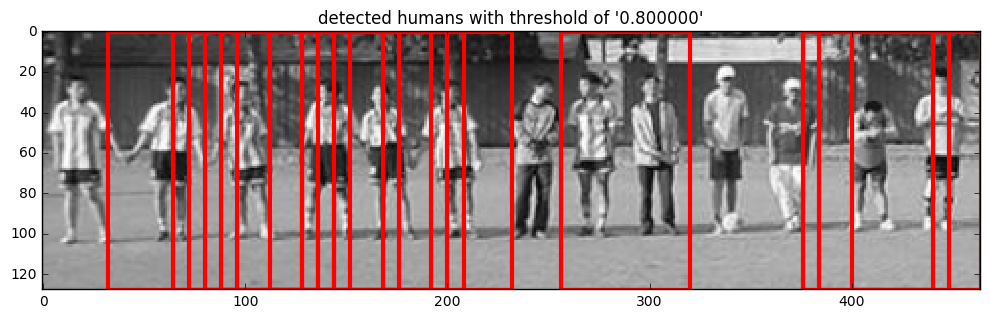

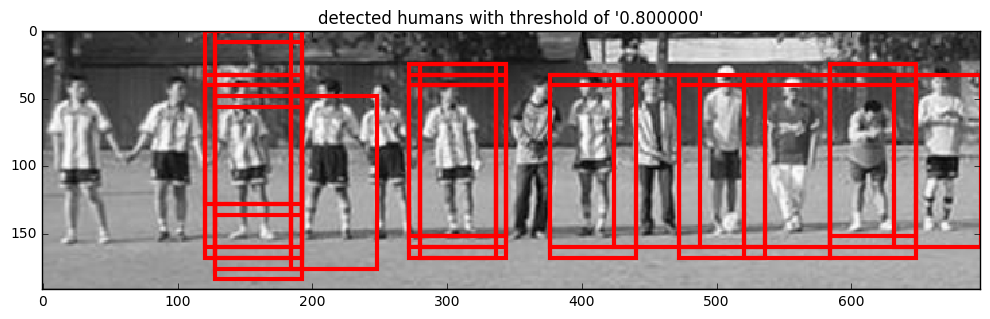

In [9]:
testpic = io.imread('images/pedestrian_test/9Cup10.bmp')
threshold = 0.80
output1 = pyramid(testpic, threshold, limits[2])

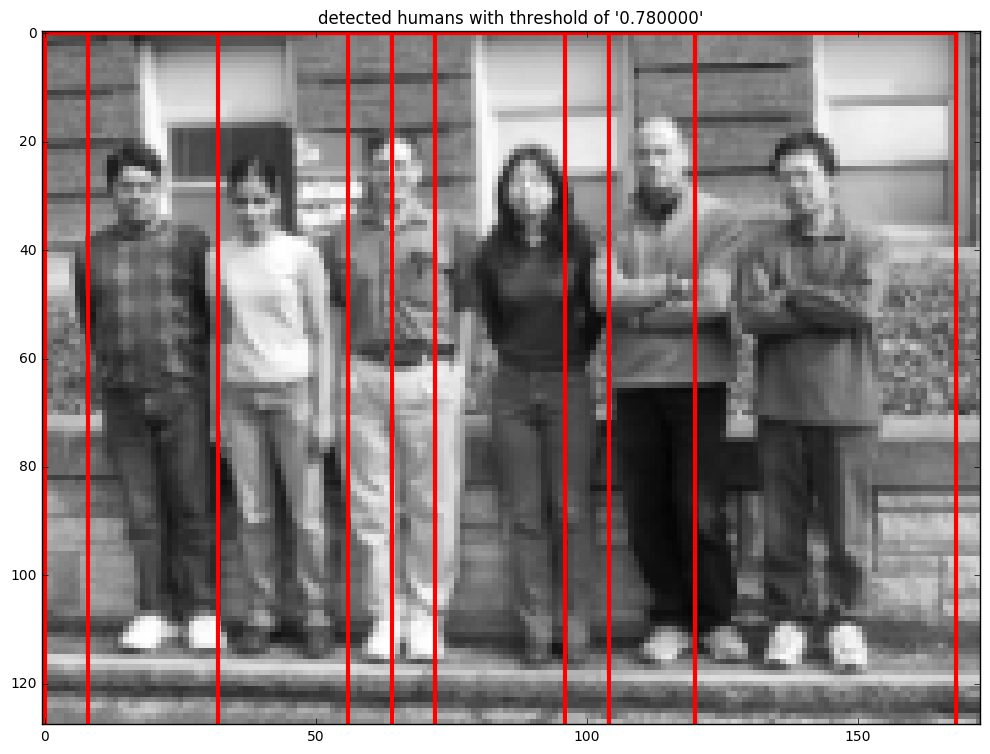

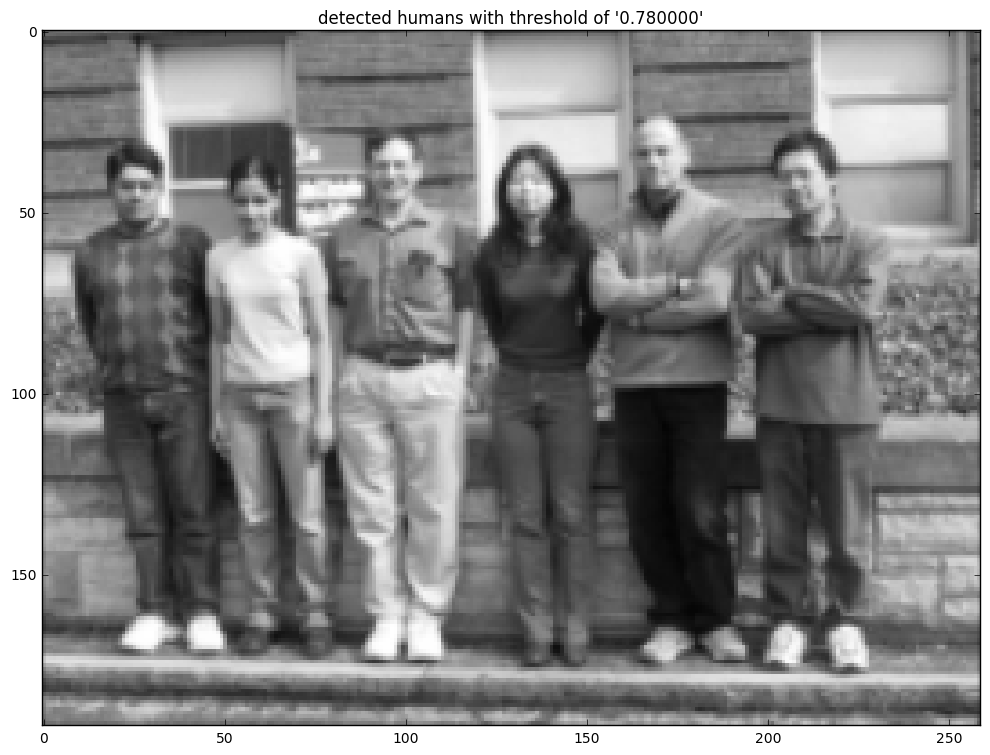

In [10]:
testpic = io.imread('images/pedestrian_test/group_5.bmp')
threshold = 0.78
output2 = pyramid(testpic, threshold, limits[2])

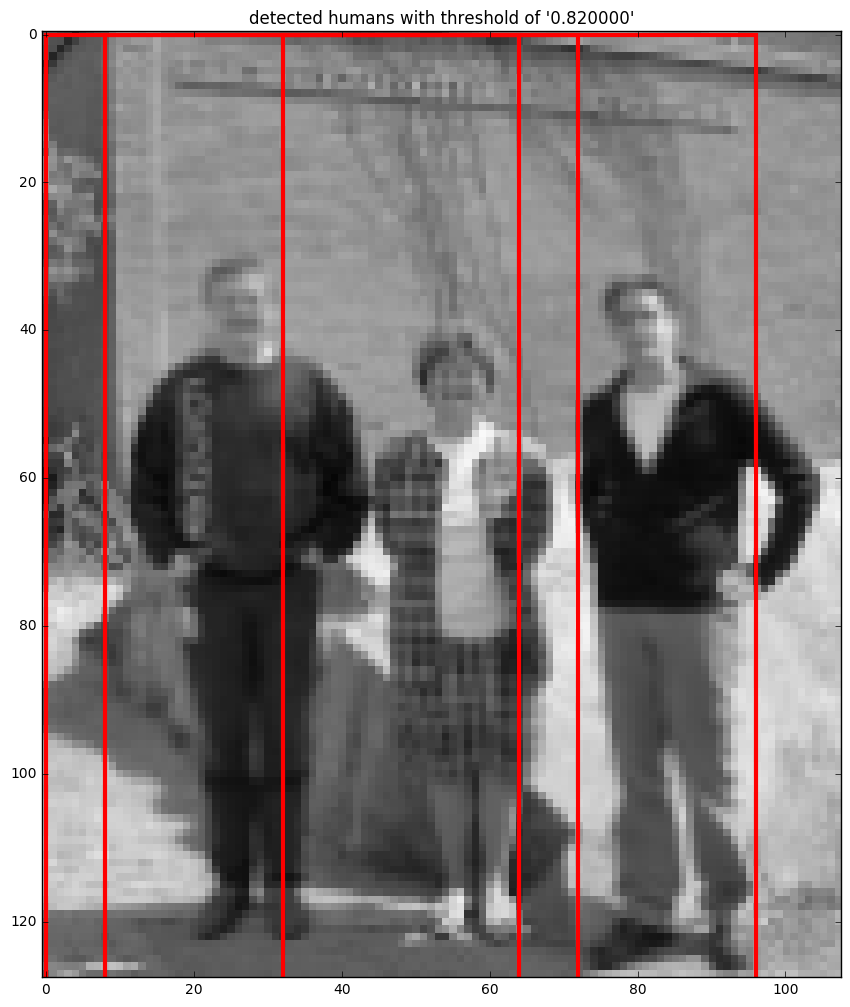

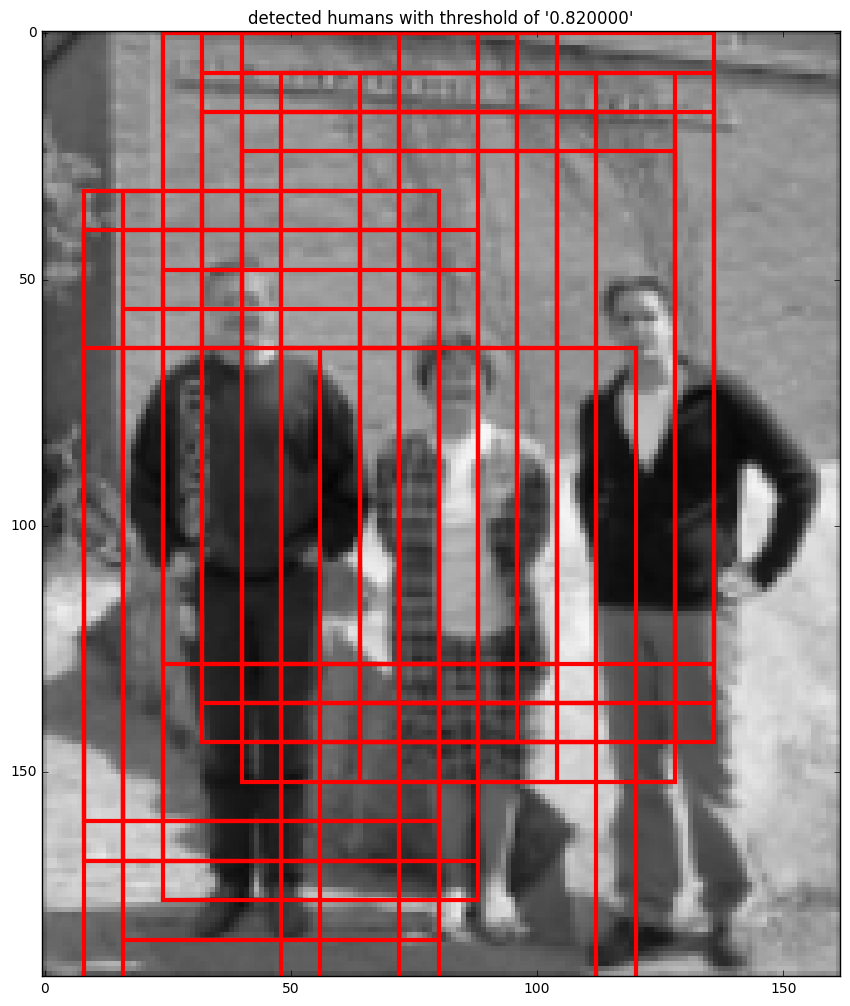

In [12]:
testpic = io.imread('images/pedestrian_test/group_143.bmp')
threshold = 0.82
output5 = pyramid(testpic, threshold, limits[2])

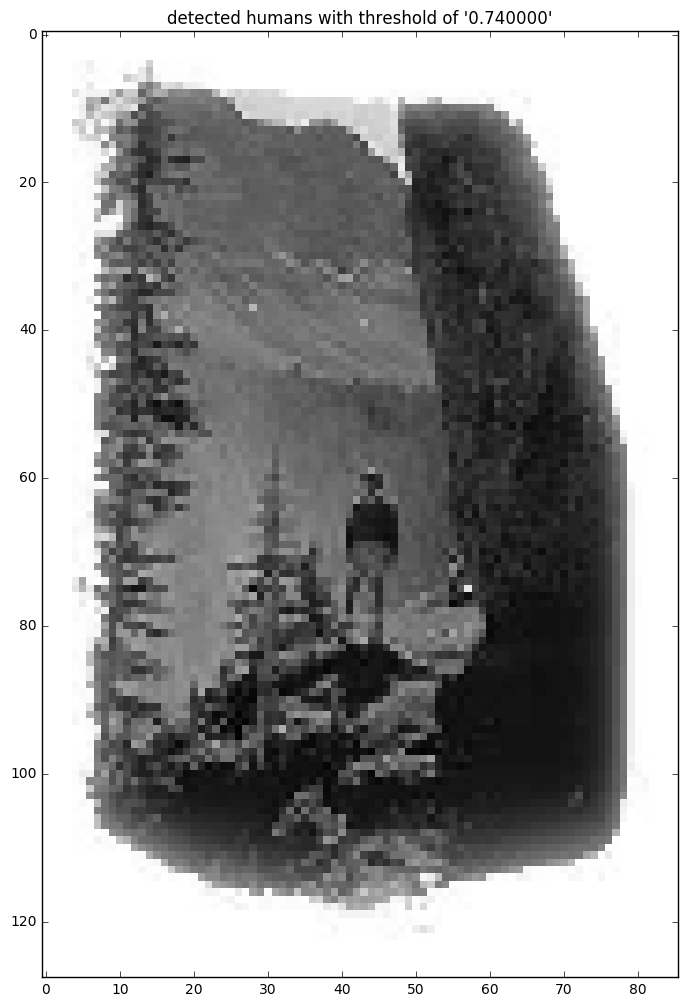

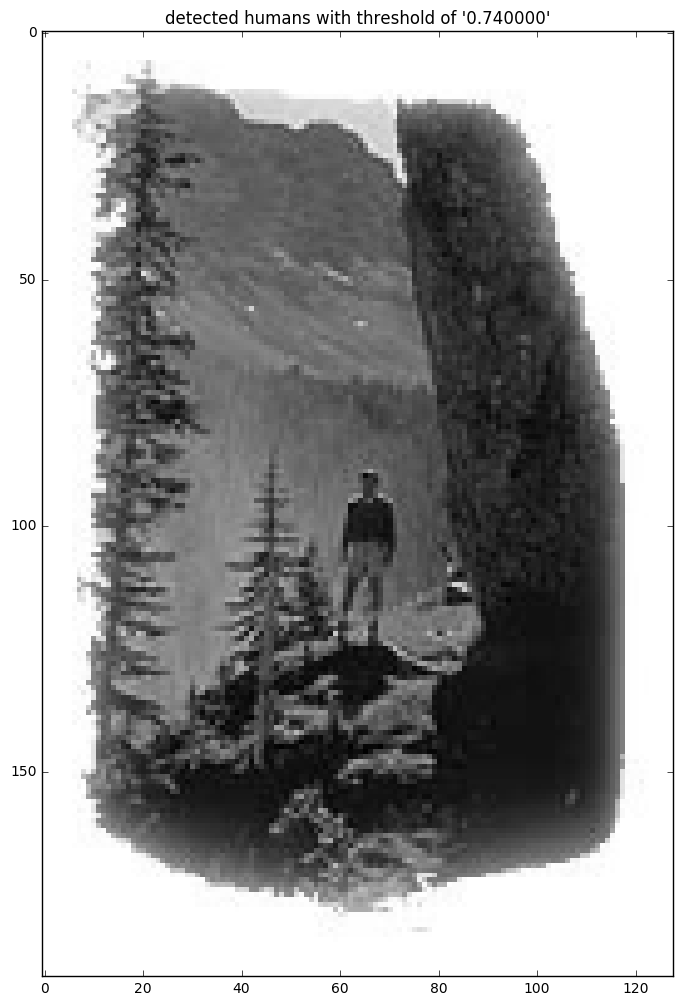

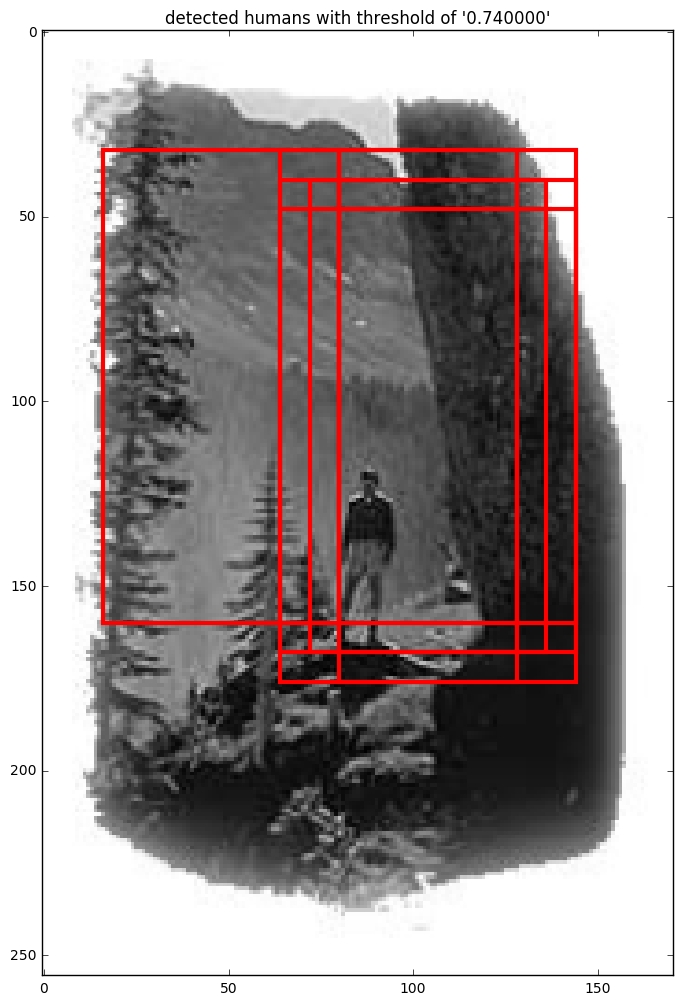

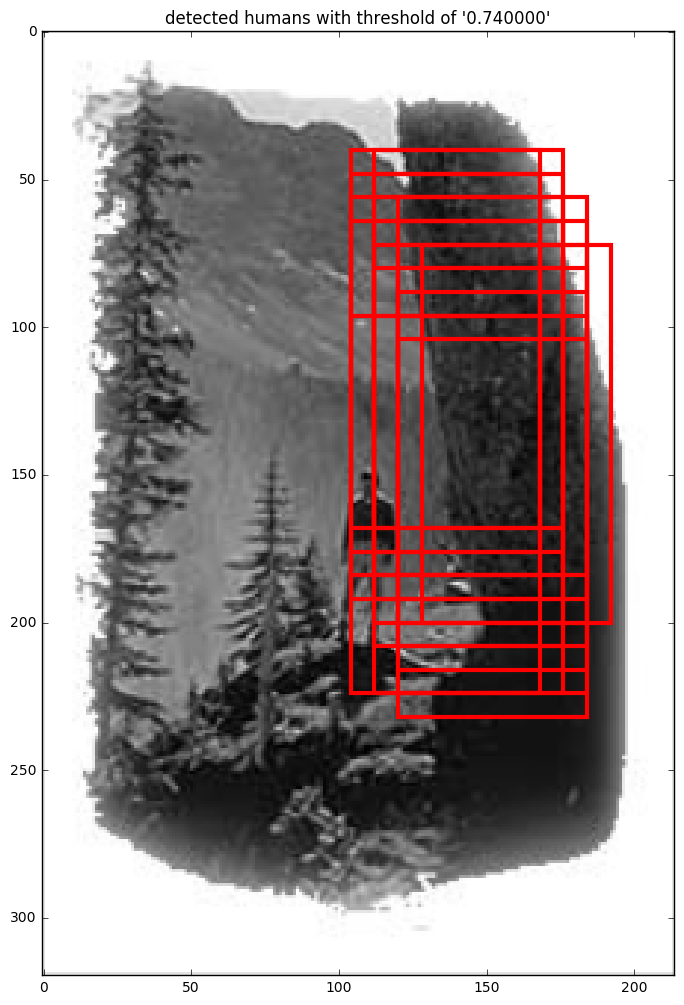

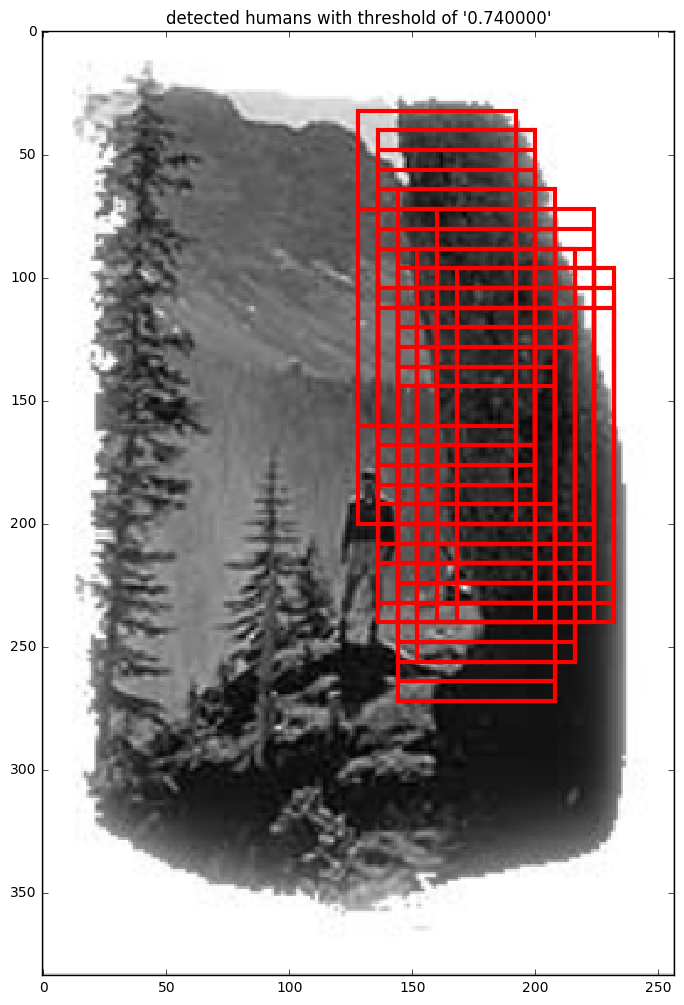

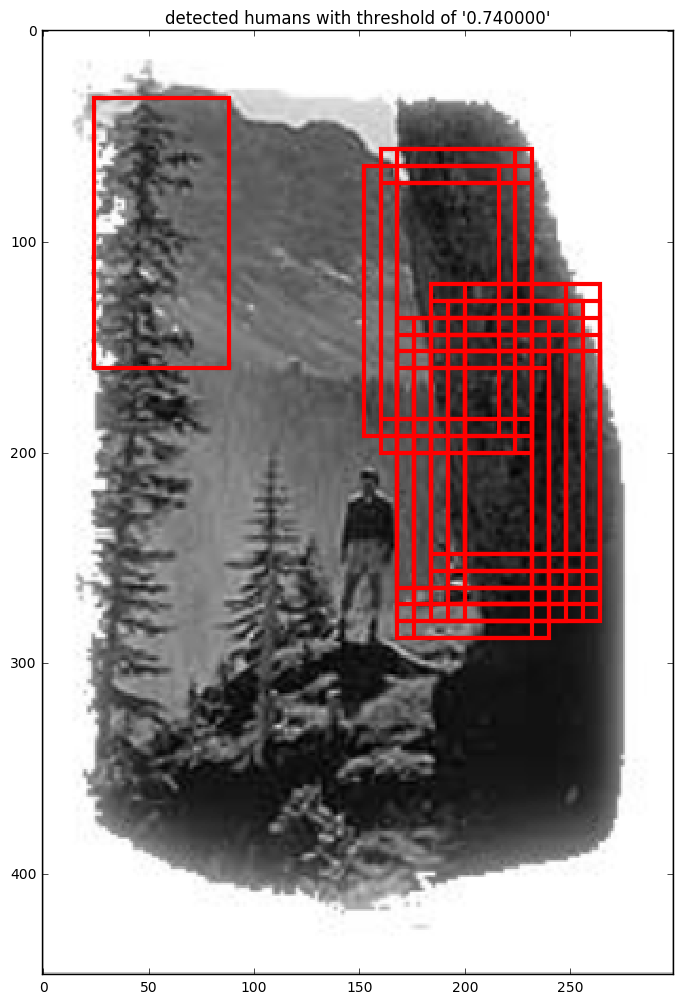

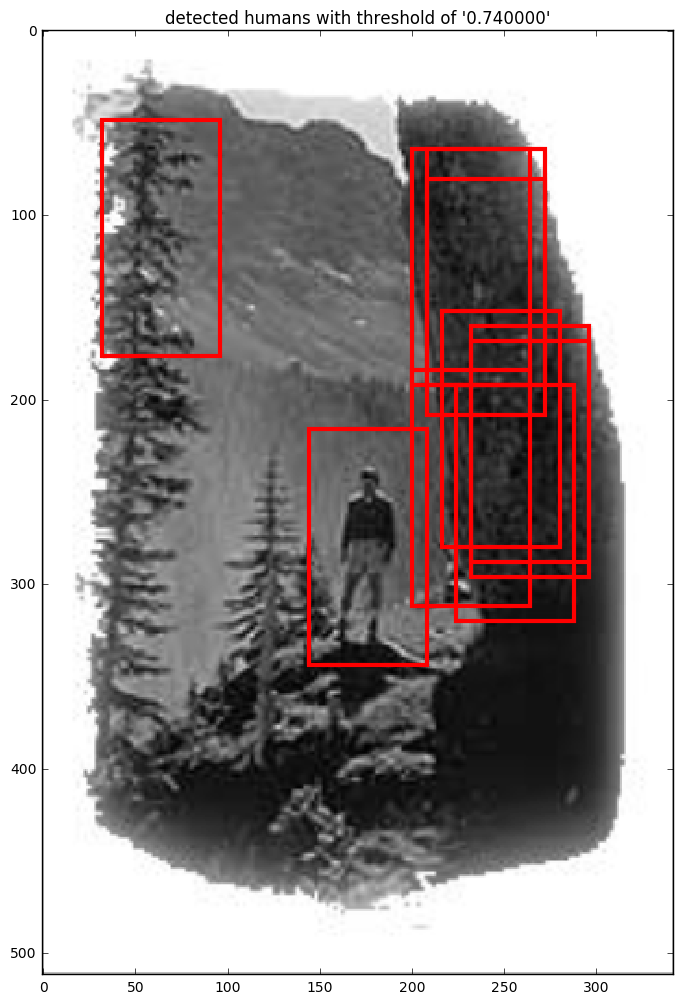

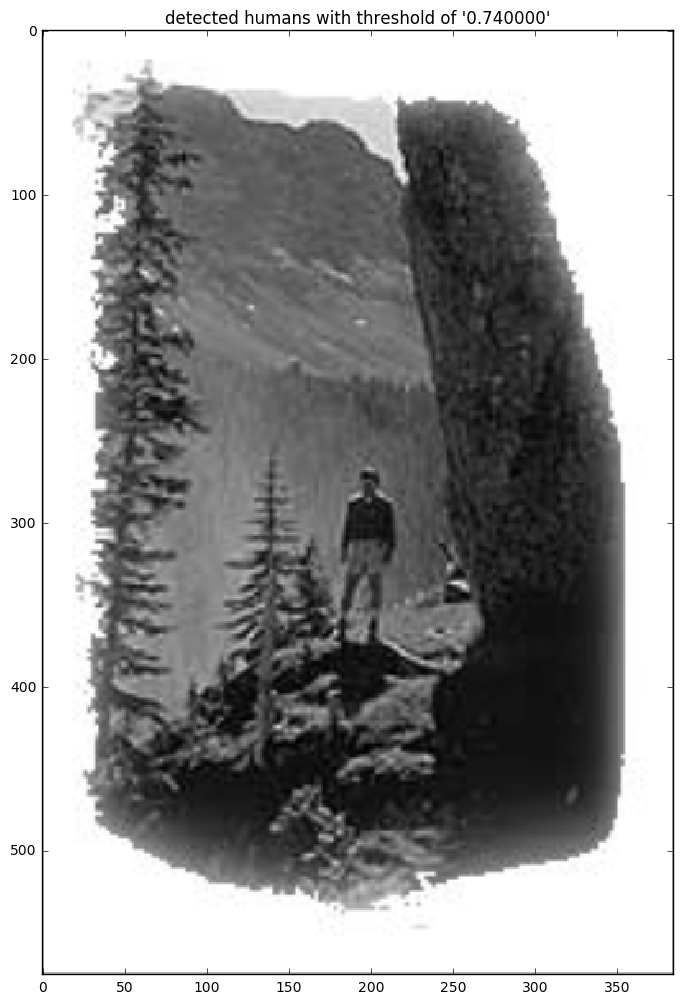

In [13]:
testpic = io.imread('images/pedestrian_test/hiker_14.bmp')
threshold = 0.74
output6 = pyramid(testpic, threshold, limits[8])
#best: 2017-01-08_16-11-15-358337

bestes Ergebnis:

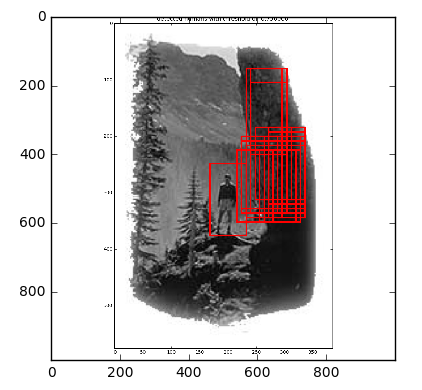

In [24]:
io.imshow('images/pediOutput/2017-01-08_16-11-15-358337.png')

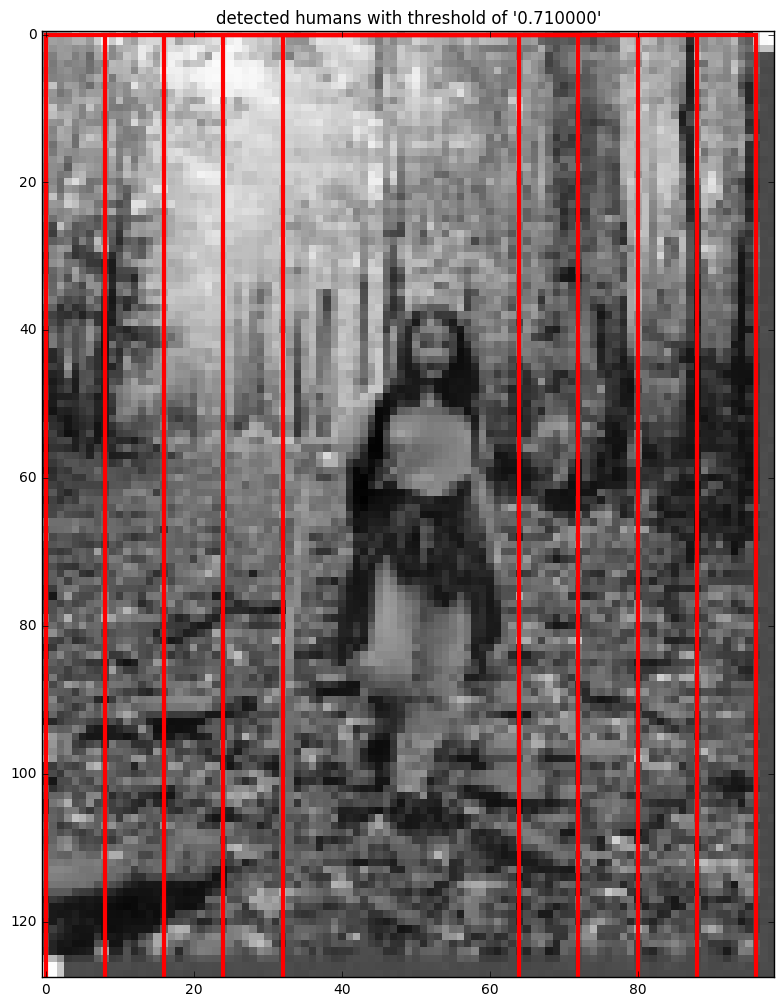

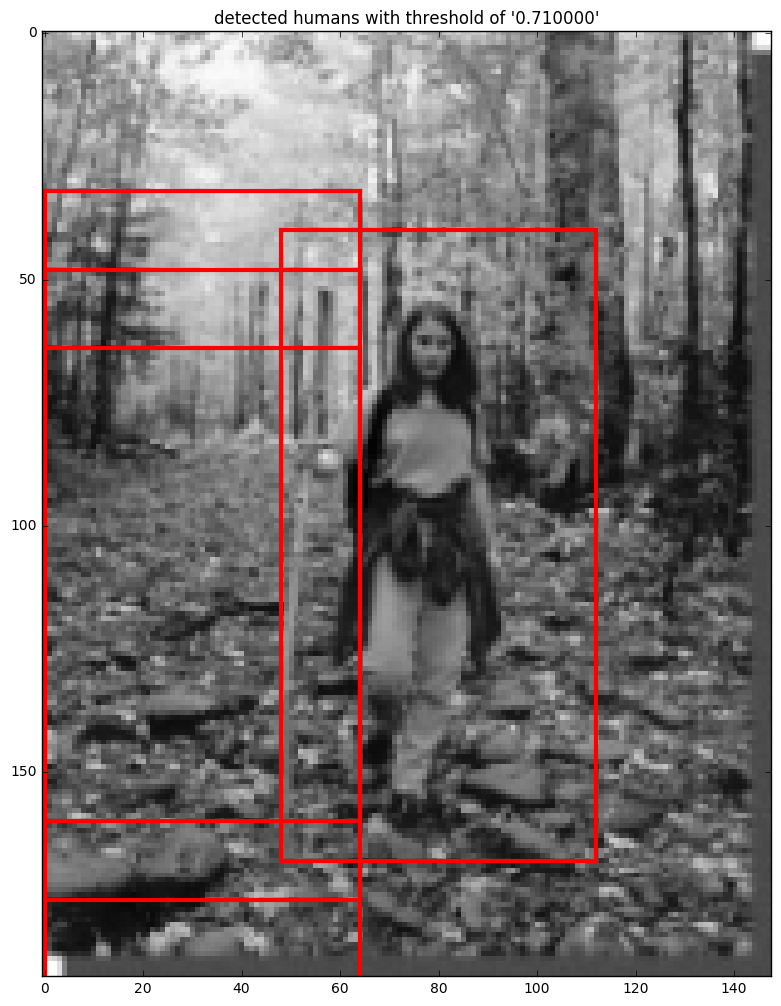

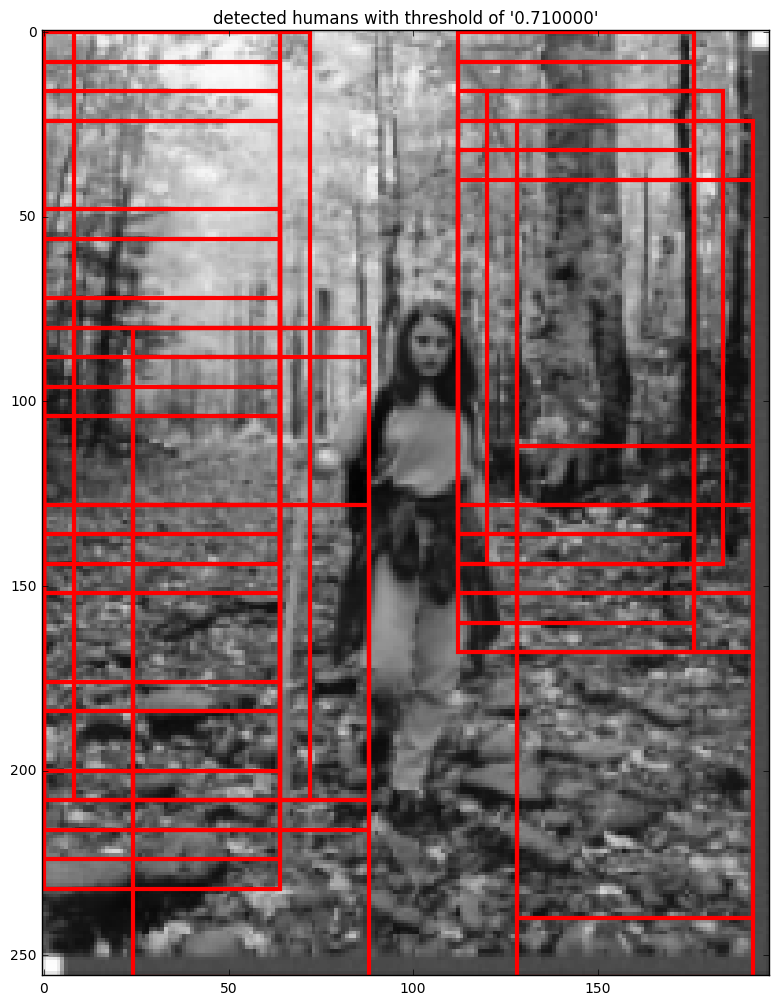

In [16]:
testpic = io.imread('images/pedestrian_test/hiker_16.bmp')
threshold = 0.71
output8 = pyramid(testpic, threshold, limits[3])

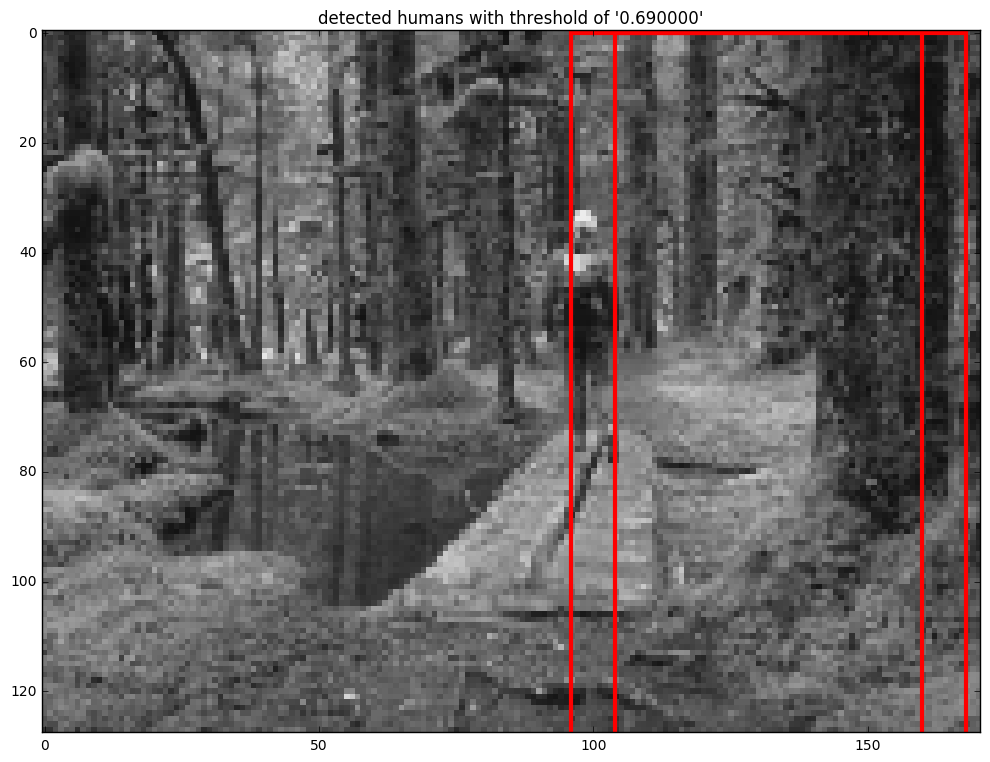

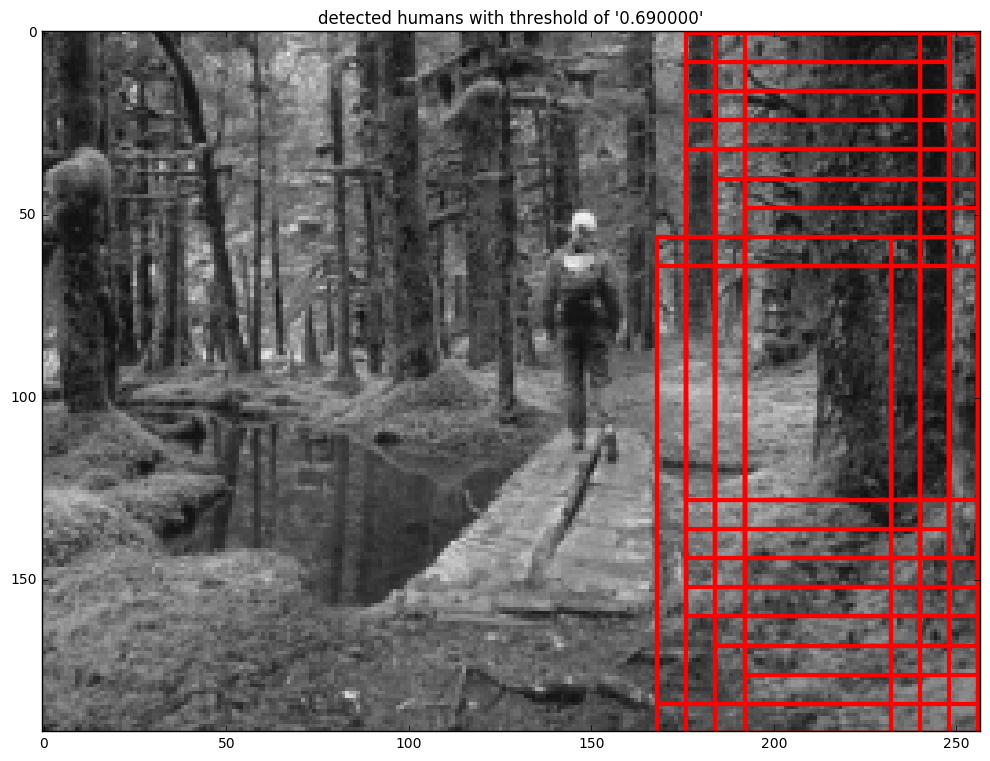

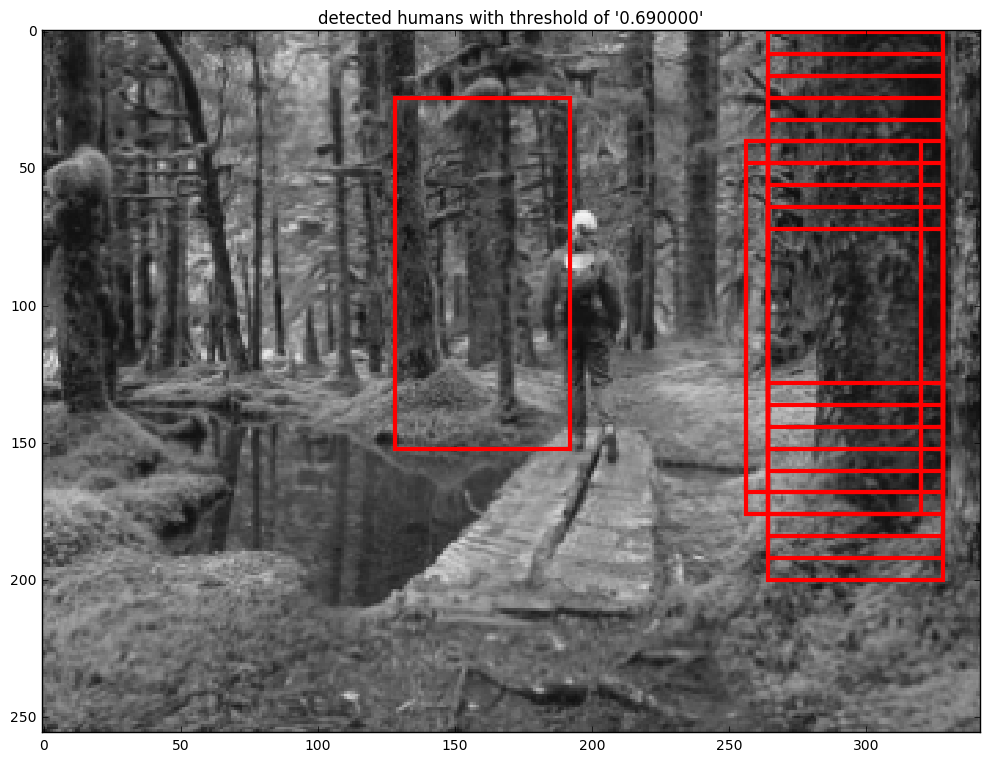

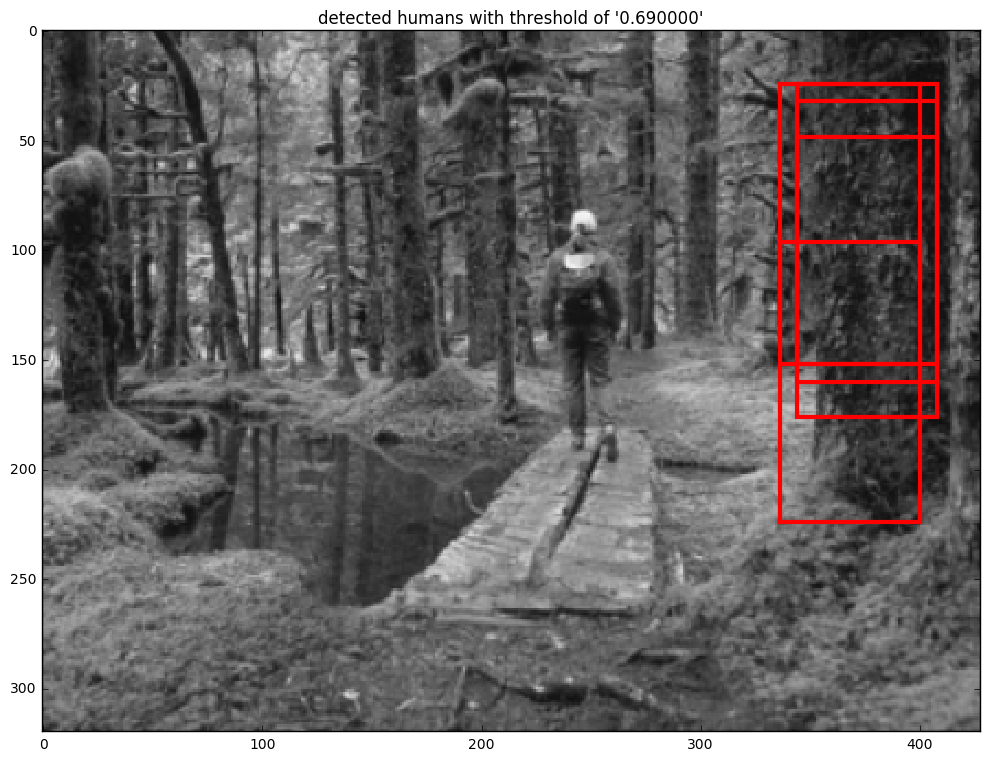

In [19]:
testpic = io.imread('images/pedestrian_test/hiker_30.bmp')
threshold = 0.69
output10 = pyramid(testpic, threshold, limits[4])

bestes Ergebnis:

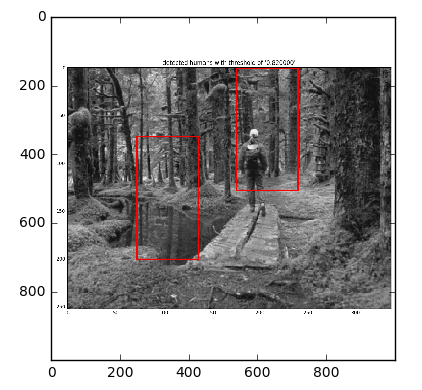

In [21]:
io.imshow('images/pediOutput/2017-01-07_21-05-14-237179.png')

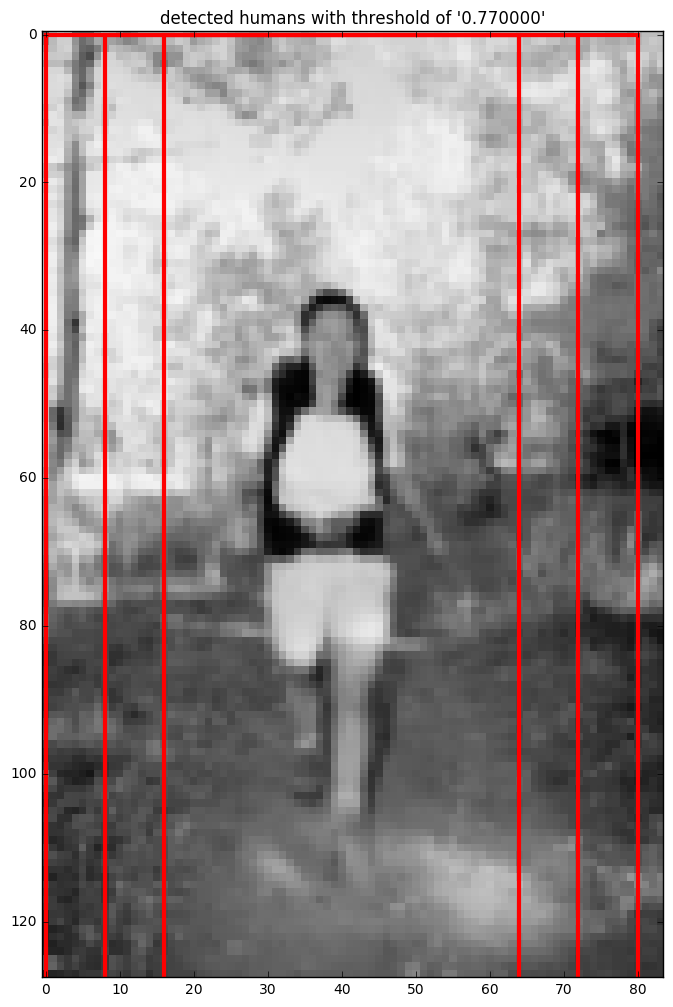

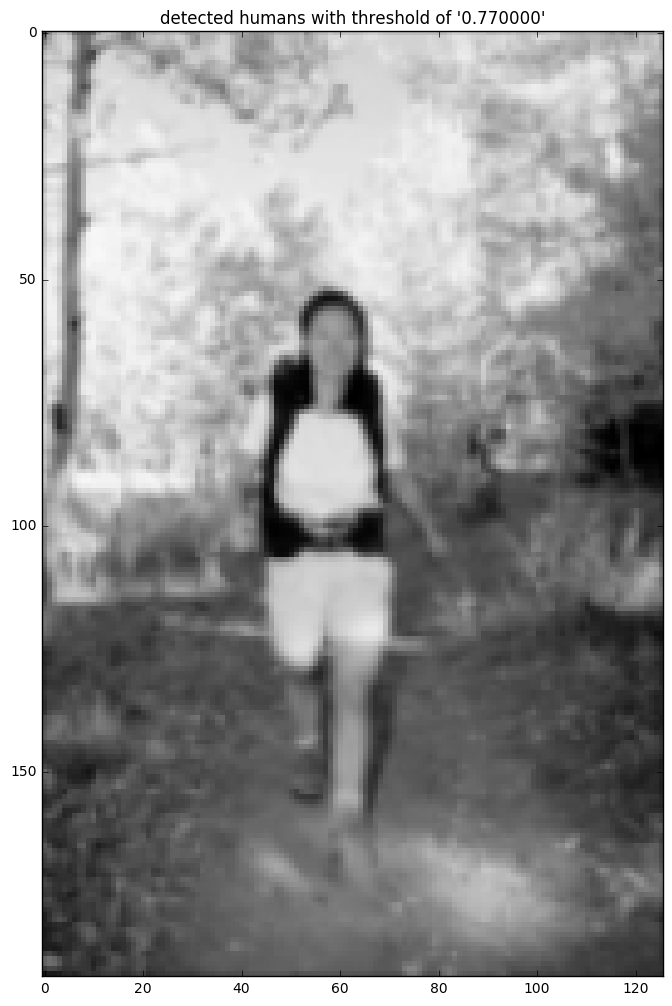

In [22]:
testpic = io.imread('images/pedestrian_test/hiker_62.bmp')
threshold = 0.77
output11 = pyramid(testpic, threshold, limits[2])

bestes Ergebnis:

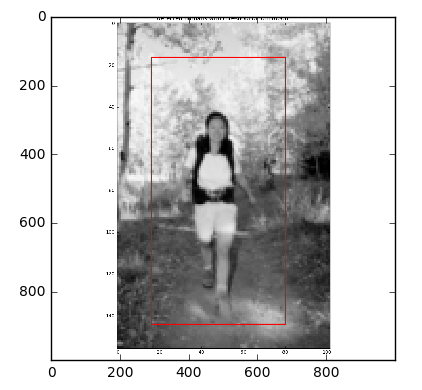

In [23]:
io.imshow('images/pediOutput/2017-01-07_21-06-48-954764.png')

In [ ]:
testpic = io.imread('images/pedestrian_test/hiker_64.bmp')
threshold = 0.78
#output12 = pyramid(testpic, threshold, limits[3])

In [ ]:
testpic = io.imread('images/pedestrian_test/hiker_117.bmp')
threshold = 0.78
#output13 = pyramid(testpic, threshold, limits[3])

In [ ]:
testpic = io.imread('images/pedestrian_test/hiker_152.bmp')
threshold = 0.80 #0.82
#output14 = pyramid(testpic, threshold, limits[2])

In [ ]:
testpic = io.imread('images/pedestrian_test/hiking_105.bmp')
threshold = 0.80 #0.82
#output15 = pyramid(testpic, threshold, limits[2])

In [ ]:
testpic = io.imread('images/pedestrian_test/hiking_412.bmp')
threshold = 0.82
#output16 = pyramid(testpic, threshold, limits[2])

In [ ]:
testpic = io.imread('images/pedestrian_test/hiking_439.bmp')
threshold = 0.82
#output17 = pyramid(testpic, threshold, limits[1])